In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import os
from sklearn.metrics import auc
from utils import get_percentile, import_graph

METRICS_LIST = ['degrees', 'k_cores', 'eccentricity', 'betweenness_centrality']
graph_names = ['wikivote', 'hamsterster', 'DCAM', 'gnutella', 'github', 'dblp2010']
method_names = ['RC','RW','BFS','DFS','MOD','DE']
METHOD_COLOR = {
    'AFD':'pink',
    'RC':'grey',
    'RW':'green',
    'DFS':'black', 
    'BFS':'blue', 
    'DE':'magenta', 
    'MOD':'red'
}

DUMPS_DIR = '../results/dumps_closed_shared'
SEED_COUNT = 8
TOP_PERCENTILE = 10

Load results into memory

In [9]:
def load_results(base_dir, graph):
    file_pattern = graph + r'_results_budget(\d+).json'
    budget, filename = None, None
    
    for filename in os.listdir(base_dir):
        match = re.match(file_pattern, filename)
        if match:
            budget = int(match.group(1))
            break
            
    if not budget:
        raise FileNotFoundError
    
    with open(os.path.join(base_dir, filename), 'r') as result_file:
        data = json.load(result_file)
    return data['crawler_avg'], data['history'], int(budget)

In [10]:
# draw plot 

def draw_nodes_history(history, crawler_avg, print_methods, graph_name, seed_count, budget):
    """
    Drawing history for every method(average are bold) and every seed(thin)
    """
    # TBD - ,graph_name,seed_count are only for filenames. need to clean them
    plt.figure(figsize=(10, 10))
    plt.grid()
    
    auc_res = {}
    
    for method, method_data in history.items():
        if method in print_methods:
            auc_res[method] = {}
            for seed_num, seed_data in list(method_data.items())[:seed_count]:
                data = np.array(seed_data['nodes'][:budget])
                auc_res[method][seed_num] = auc(x=np.arange(len(data)), y=data)
                plt.plot(data,
                         linewidth=0.5,
                         color=METHOD_COLOR[method])
    maxmethod = np.zeros(budget)         
    for i in range(budget):
        for method in print_methods:
            if crawler_avg[method]['nodes'][i]>maxmethod[i]:
                maxmethod[i] = crawler_avg[method]['nodes'][i]
    
    #maxmethod = np.array([np.max(i) for i in [crawler_avg[method]['nodes']] for method in crawler_avg])])
    print('maxmethod',maxmethod )
    for method, avg_data in crawler_avg.items():
        if method not in print_methods:
            continue
        data = np.array(avg_data['nodes'][:budget])
        auc_res[method]['average'] = auc(x=np.arange(len(data)), y=data)
        plt.plot(data-maxmethod,
                 linewidth=4,
                 color=METHOD_COLOR[method],
                 label=method)

    plt.legend()
    plt.savefig('../results/history/' + graph_name + '_history_' +
                str(seed_count) + '_seeds_' +
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res
    
def draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, seed_count,
                            budget):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plt.figure(figsize=(20, 20))
    
    auc_res = {}
    
    for method in print_methods:
        auc_res[method] = {}
        for prop in METRICS_LIST:
            # ремап для красивой отрисовки 2*2
            j = {'degrees': 0, 'k_cores': 1, 'eccentricity': 2, 'betweenness_centrality': 3}[prop] 
            
            data = np.array(crawler_avg[method][prop][:budget]) / seed_count / \
                   len(percentile_set[prop])
            auc_res[method][prop] = auc(x=np.arange(len(data)), y=data)
            axs[j // 2][j % 2].plot(data,
                                    label=method,
                                    color=METHOD_COLOR[method])
            axs[j // 2][j % 2].set_title(
                graph_name + '% nodes with ' + prop + ' from ' + str(len(percentile_set[prop])))
            axs[j // 2][j % 2].legend()

        axs[j // 2][j % 2].grid(True)
    fig.savefig('../results/history/' + graph_name + '_scores_' + 
                str(seed_count) + '_seeds_' + 
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res

def plot_graph(graph_name, print_methods, budget_slices):
    crawler_avg, history, max_budget = load_results(DUMPS_DIR, graph_name)
    budget_slices.append(max_budget)
    
    big_graph = import_graph(graph_name)
    # берём топ 10 процентов вершин
    percentile, percentile_set = get_percentile(big_graph, graph_name, TOP_PERCENTILE)    
    
    if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
        percentile_set['eccentricity'] = set(big_graph.nodes()).\
            difference(percentile_set['eccentricity'])
    
    for budget_slice in budget_slices:
        auc_res = draw_nodes_history(history, crawler_avg, print_methods, graph_name, SEED_COUNT, budget_slice)
        print('Nodes AUC for budget: '+ str(budget_slice) + ' ' + str(auc_res))
        
    auc_res = draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, SEED_COUNT,
                            max_budget)
    print('Properties AUC: ' + str(auc_res))
    

Wikivote nodes: 889 edges: 2914

maxmethod [ 17.25   36.625  53.875  79.875  87.5   106.25  116.    125.5   134.
 140.375 149.5   153.5   165.875 174.25  179.875 190.625 197.75  206.25
 218.375 228.5   235.125 239.125 242.625 245.25  251.25  261.125 264.375
 267.25  269.375 272.75  279.    281.75  287.125 289.375 298.125 300.5
 302.5   305.375 306.625 310.875 313.25  315.25  318.375 322.25  325.625
 328.75  336.25  338.625 339.75  341.5   343.875 346.25  350.375 355.375
 362.25  363.75  367.625 374.75  383.625 386.25  390.5   395.5   397.125
 398.875 402.    404.25  405.5   407.875 411.625 413.    415.25  418.25
 420.5   423.    424.625 432.125 436.25  438.625 440.125 441.75  444.75
 447.5   449.125 450.    451.25  453.    454.625 456.5   457.625 459.25
 461.75  462.875 465.    470.375 473.875 475.    477.    479.25  481.25
 483.   ]
Nodes AUC for budget: 100 {'DFS': {'628': 20965.5, '123': 19327.0, '139': 19500.5, '885': 27872.5, '4': 22682.0, '536': 28779.0, '792': 28015.5, '784': 29457.0, 'average': 24574.875}, 'RW

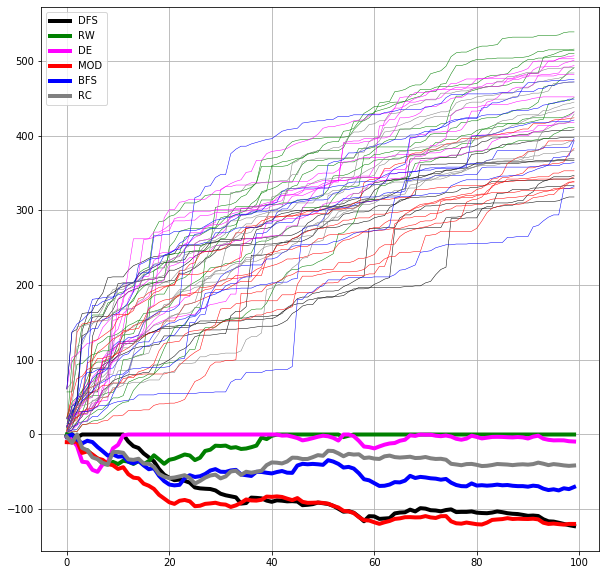

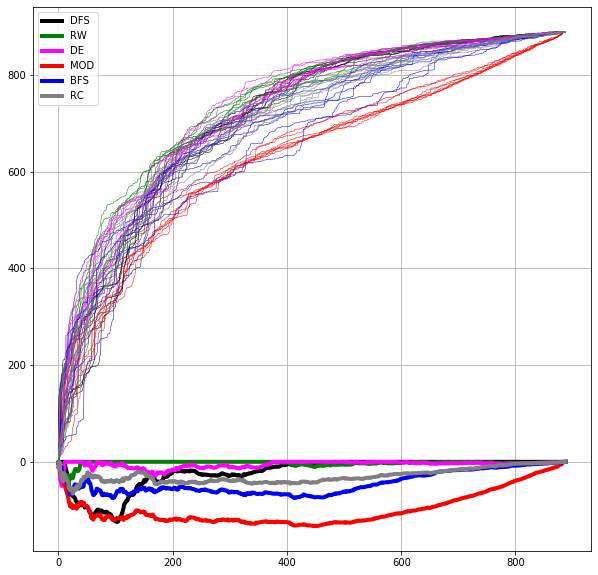

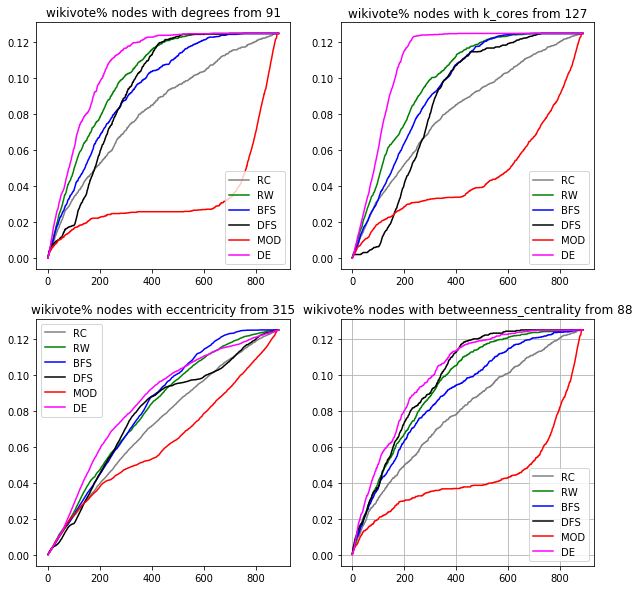

<Figure size 1440x1440 with 0 Axes>

In [11]:
plot_graph(graph_names[0], ['RC','RW','BFS','DFS','MOD','DE'], [100]) 

hamsterster nodes: 2000 edges: 16097

maxmethod [  30.      77.75   110.75   134.     163.875  193.625  219.25   259.125
  277.375  282.     303.875  322.5    353.375  391.125  399.5    404.75
  410.125  418.125  425.5    436.75   447.75   467.5    481.5    488.125
  494.875  504.75   532.375  561.375  565.875  578.125  586.375  599.625
  628.5    636.5    642.25   648.25   655.     661.625  669.     682.75
  695.25   701.125  705.5    719.375  724.875  729.     735.125  744.125
  748.75   754.75   773.125  787.     798.5    810.375  827.     834.75
  851.     866.375  879.75   894.375  905.625  916.     925.5    929.625
  945.875  952.125  957.75   963.     974.375  981.625  986.25   999.125
 1009.125 1013.5   1021.375 1026.5   1035.75  1038.125 1041.25  1044.625
 1047.625 1054.    1057.625 1062.25  1066.25  1074.75  1077.    1080.75
 1081.75  1084.875 1086.625 1088.625 1096.25  1099.    1105.125 1107.
 1110.375 1111.625 1118.5   1122.875]
Nodes AUC for budget: 100 {'DE': {'1353': 62298.5, '38': 76147.0, '1026': 73451.5, 

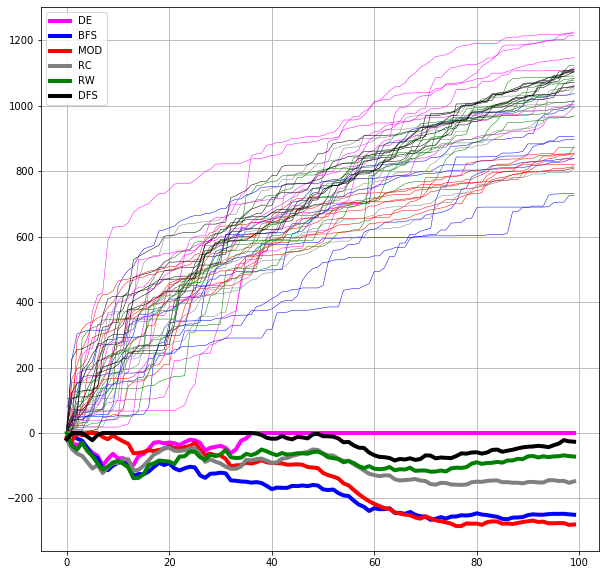

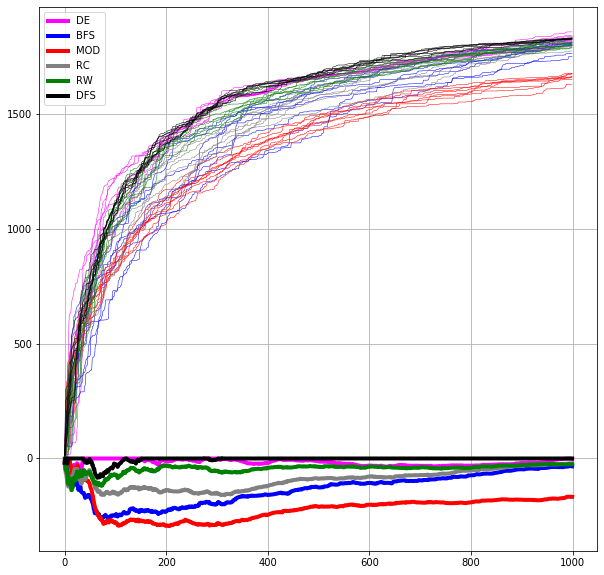

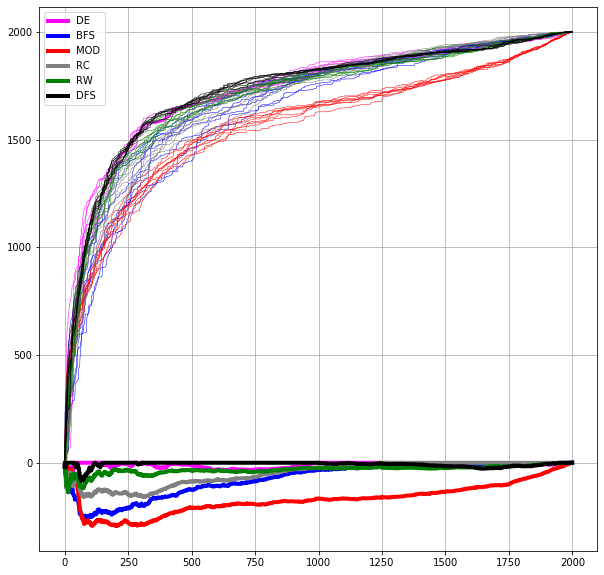

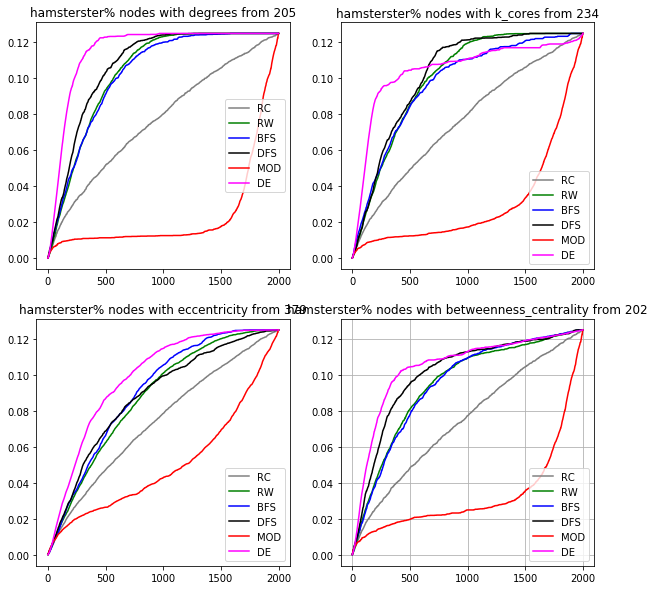

<Figure size 1440x1440 with 0 Axes>

In [12]:
plot_graph(graph_names[1], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000]) 

DCAM nodes: 2752 edges: 68741

maxmethod [  67.5    273.25   387.     480.75   515.625  540.125  641.5    669.
  704.375  760.75   778.25   798.75   817.5    823.5    837.     865.
  903.75   947.75   991.375 1014.875 1098.625 1118.125 1144.625 1162.625
 1186.625 1199.75  1220.625 1257.5   1278.75  1292.5   1322.875 1330.625
 1339.125 1356.375 1368.    1374.625 1383.    1400.    1408.    1415.75
 1421.375 1427.25  1437.25  1445.625 1451.25  1456.5   1464.    1472.125
 1482.    1492.125 1499.25  1505.625 1515.375 1522.75  1529.875 1543.125
 1551.625 1558.875 1567.75  1576.625 1589.125 1601.375 1607.5   1610.625
 1621.625 1642.875 1651.125 1659.375 1665.    1668.875 1672.375 1679.5
 1684.    1687.5   1689.125 1692.875 1695.5   1698.375 1702.    1706.375
 1707.5   1709.875 1712.75  1715.75  1719.    1722.    1724.125 1727.
 1729.75  1733.5   1735.75  1738.5   1742.5   1744.75  1746.875 1751.375
 1761.625 1765.    1770.5   1775.875]
Nodes AUC for budget: 100 {'RW': {'811911': 133235.5, '72291006': 121308.5, '122069986':

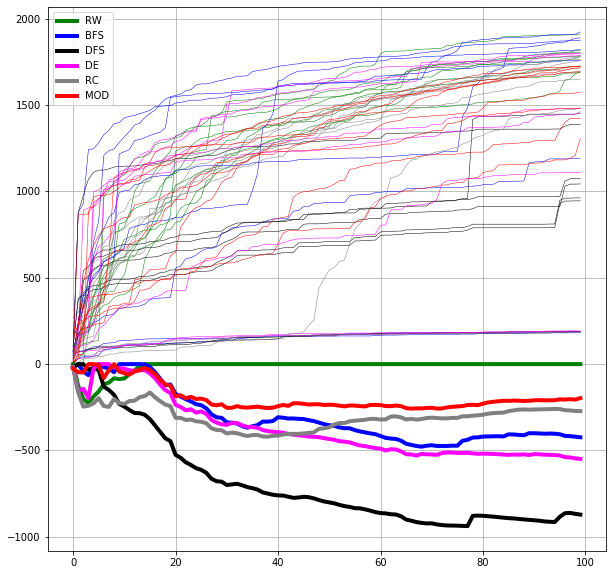

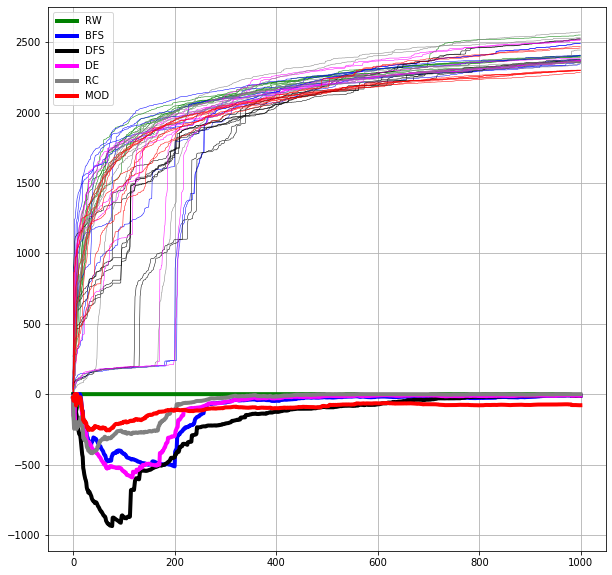

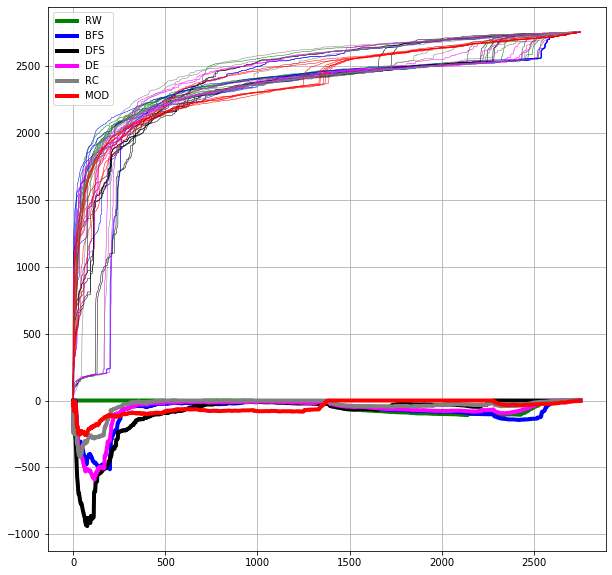

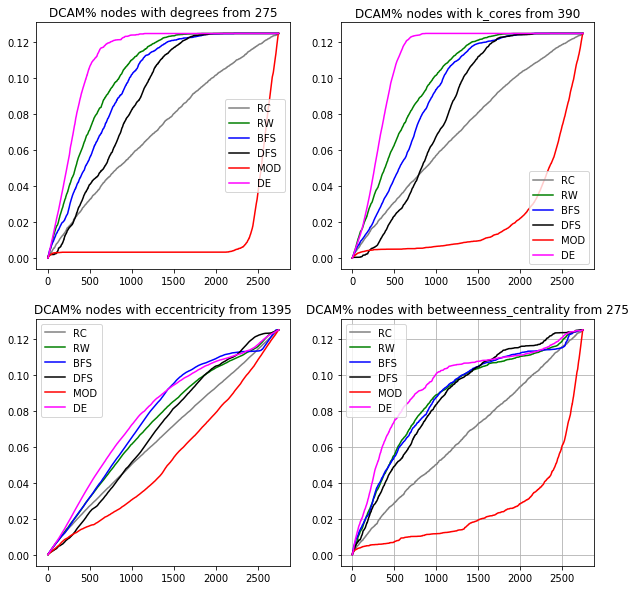

<Figure size 1440x1440 with 0 Axes>

In [13]:
plot_graph(graph_names[2], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000]) 

gnutella nodes: 36682 edges: 88328

In [14]:
plot_graph(graph_names[3], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000]) 

FileNotFoundError: 

github nodes: 120865 edges: 439858

In [ ]:
plot_graph(graph_names[4], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000, 100000]) 
 

dblp2010 nodes: 226413 edges: 716460

In [ ]:
plot_graph(graph_names[5], ['RC','RW','BFS','DFS','MOD'], [100, 1000, 10000, 100000]) 